<a href="https://colab.research.google.com/github/henritremey/tdl/blob/main/Projet(TP3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Apprentissage Profond :


## Chargement des données
La base de données est à télécharger depuis Git.

In [ ]:
!git clone https://github.com/LeopoldLopez/ProjetAP.git
path = "./ProjetAP/Données_Triee"


fatal: destination path 'ProjetAP' already exists and is not an empty directory.


Chargement des données dans des tenseurs $x$ et $y$ de dimensions respectives $(N, 64, 64, 3)$ et $(N, 1)$, où $N$ désigne le nombre d'éléments de l'ensemble considéré (apprentissage, validation, ou test).

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
image_size = 64
def load_data(data_path, classes, dataset='train', image_size=64):
    num_images = 0

    for class_name in classes:
        class_dir = os.path.join(data_path, dataset, class_name)
        # Compter le nombre d'images dans le répertoire de chaque classe
        num_images += sum(1 for item in os.listdir(class_dir) if not item.startswith('.'))

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    current_index = 0

    # Parcourir les différents répertoires pour collecter les images
    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            if not item.startswith('.'):
                item_path = os.path.join(class_dir, item)
                if os.path.isfile(item_path):
                    # Ouvrir l'image
                    img = Image.open(item_path)
                    # Conversion en RGB
                    img = img.convert('RGB')
                    # Redimensionnement de l'image et écriture dans la variable de retour x
                    img = img.resize((image_size, image_size))
                    x[current_index] = np.asarray(img)
                    # Écriture du label associé dans la variable de retour y
                    y[current_index] = class_index
                    current_index += 1

    return x, y


labels = ['Bleuets', 'Jacinthes', 'Jonquille', 'Lily_of_the_valley', 'Marguerites', 'Orchidee','Peony', 'Rose', 'Tournesol', 'Violettes']

x_train, y_train = load_data(path, labels, dataset='train', image_size=64)
x_train = x_train/255
x_val, y_val = load_data(path, labels, dataset='validation', image_size=64)
x_val = x_val/255
x_test, y_test = load_data(path, labels, dataset='test', image_size=64)
x_test = x_test/255

### Visualisation des images

<ipython-input-6-1ac4d07d4e1d>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(y_train[shuffle_indices[i]])])


['Bleuets', 'Jacinthes', 'Jonquille', 'Lily_of_the_valley', 'Marguerites', 'Orchidee', 'Peony', 'Rose', 'Tournesol', 'Violettes']


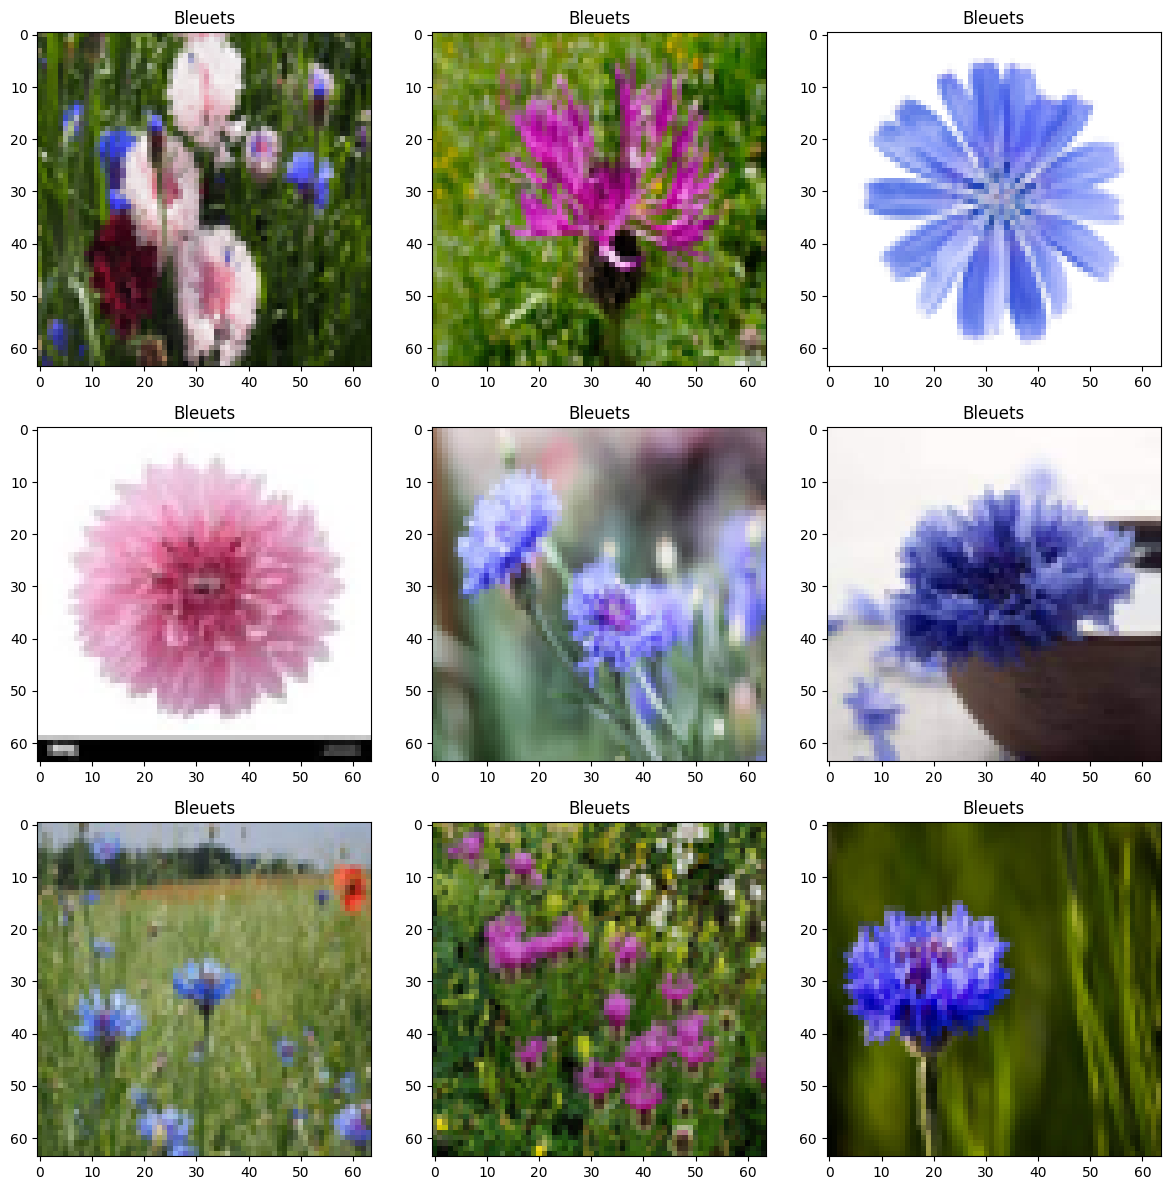

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(9)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image)

print(labels)
plt.tight_layout()
plt.show()

## Première approche : réseau convolutif de base comme utilisé dans le TP3

Les images ont toutes été redimensionnées en $64 \times 64$.
Vous devez définir un réseau de neurones convolutif en suivant ce schéma pour la base convolutive :

<center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center>
<caption><center><b> Figure 2: Vue de l'architecture à implémenter </b></center></caption>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2).

La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128. Enfin, avant la couche de sortie, vous ajouterez une couche dense comptant 512 neurones. Vous aurez donc construit un réseau à 6 couches, sorte de version simplifiée d'AlexNet.

Pour construire ce réseau, vous pouvez utiliser les fonctions Conv2D, Maxpooling2D, et Flatten de Keras.

In [48]:
import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers


model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

### Entrainement

Evaluation quantitative avec matrice de confusion
Evaluation qualitative en prenant les images une par une et en regardant pk il se trompe

Pour l'entraînement, vous pouvez utiliser directement les hyperparamètres suivants.

In [49]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])


... puis lancer l'entraînement. **Attention : si jamais vous voulez relancer l'entraînement, il faut réinitialiser les poids du réseau. Pour cela il faut re-exécuter les cellules précédentes à partir de la définition du réseau !** Sinon vous risquez de repartir d'un entraînement précédent (qui s'est éventuellement bien, ou mal déroulé) et mal interpréter votre nouvel entraînement.

#### Sans Augmentation de données

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=10, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32,callbacks=[checkpoint, early_stopping])
model.summary()

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 2.0610 - sparse_categorical_accuracy: 0.2320
Epoch 1: val_loss improved from inf to 1.69601, saving model to best_model.h5
56/56 [==============================] - 7s 27ms/step - loss: 2.0610 - sparse_categorical_accuracy: 0.2320 - val_loss: 1.6960 - val_sparse_categorical_accuracy: 0.3879
Epoch 2/50
50/56 [=========================>....] - ETA: 0s - loss: 1.5664 - sparse_categorical_accuracy: 0.4019
Epoch 2: val_loss improved from 1.69601 to 1.51437, saving model to best_model.h5
56/56 [==============================] - 1s 10ms/step - loss: 1.5646 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.5144 - val_sparse_categorical_accuracy: 0.4565
Epoch 3/50
52/56 [==========================>...] - ETA: 0s - loss: 1.3665 - sparse_categorical_accuracy: 0.4952
Epoch 3: val_loss improved from 1.51437 to 1.35791, saving model to best_model.h5
56/56 [==============================] - 1s 11ms/step - loss: 1.3667 - sparse_categ

#### Avec Augmentation de données

In [50]:
import albumentations as A
import random

transform = A.Compose([
    A.ToGray(0.6),
    A.RandomRotate90(0.3),
    A.Flip(0.3),
    A.Transpose(0.3),
    A.RandomBrightnessContrast(0.5),
    A.HueSaturationValue(0.5),
    A.RGBShift(0.5),
    A.RandomGamma(0.5),
])
#On essaie de réduire la dépendance de notre réseaux au couleur d'où les fortes probabiltés sur les augmentations colorimétriques


def transform_images(x_train, y_train):
    transformed_x = []
    transformed_y = []
    for i, x in enumerate(x_train):
      if random.random() < 1.0:
        transformed_x.append(x)
        transformed_y.append(y_train[i])

        transformed_image = transform(image=(x * 255).astype(np.uint8))['image']

        transformed_x.append((transformed_image/255).astype(np.float64))
        transformed_y.append(y_train[i])

      else :
        transformed_x.append(x)
        transformed_y.append(y_train[i])

    print(np.array(transformed_x).shape)
    return np.array(transformed_x),np.array(transformed_y)

transformed_images = transform_images(x_train,y_train)


(3578, 64, 64, 3)


In [51]:
#ATTENTION n'oubliez pas de recompiler le model avant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=10, verbose=1)

history = model.fit(transformed_images[0], transformed_images[1], validation_data=(x_val, y_val), epochs=50, batch_size=32,callbacks=[checkpoint, early_stopping])
model.summary()

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 2.1884 - sparse_categorical_accuracy: 0.1901
Epoch 1: val_loss improved from inf to 1.84577, saving model to best_model.h5
112/112 [==============================] - 30s 258ms/step - loss: 2.1884 - sparse_categorical_accuracy: 0.1901 - val_loss: 1.8458 - val_sparse_categorical_accuracy: 0.2929
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.9778 - sparse_categorical_accuracy: 0.2767
Epoch 2: val_loss improved from 1.84577 to 1.55443, saving model to best_model.h5
112/112 [==============================] - 29s 263ms/step - loss: 1.9778 - sparse_categorical_accuracy: 0.2767 - val_loss: 1.5544 - val_sparse_categorical_accuracy: 0.5040
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 1.8332 - sparse_categorical_accuracy: 0.3290
Epoch 3: val_loss improved from 1.55443 to 1.38785, saving model to best_model.h5
112/112 [==============================] - 29s 263ms/step - loss: 1.8

### Analyse des résultats du modèle

Les quelques lignes suivantes permettent d'afficher l'évolution des métriques au cours de l'entraînement, sur les ensembles d'apprentissage et de validation.

In [46]:

def plot_training_analysis(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', linestyle="--", label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', linestyle="--", label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

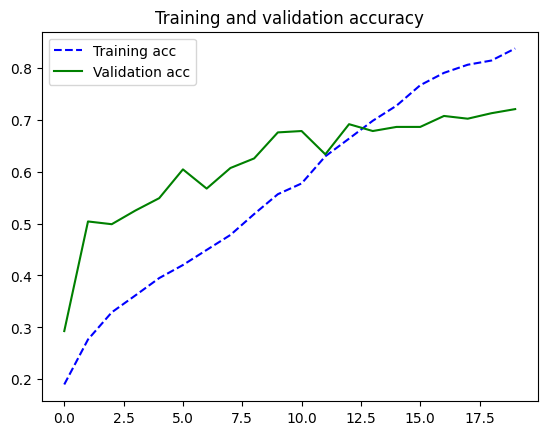

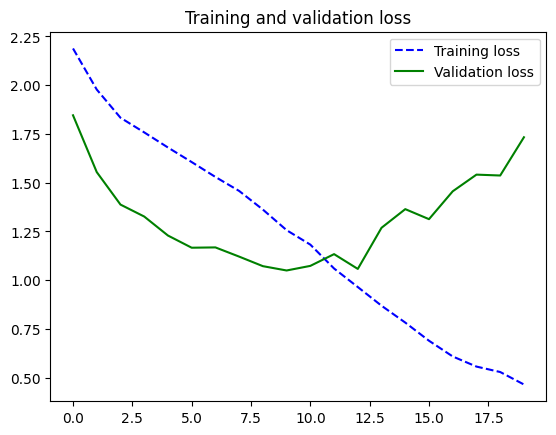

In [52]:
plot_training_analysis(history)

###Matrice de confusion

On affiche la matrice de confusion obtenue pour les données de test.

13/13 [==============================] - 1s 73ms/step


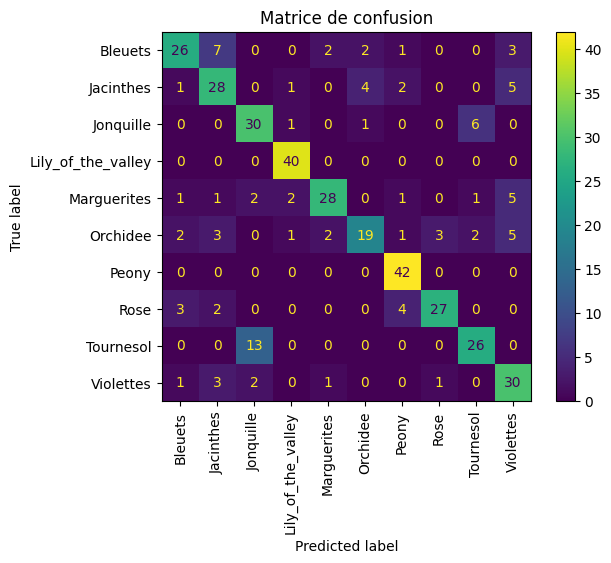

              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69        41
         1.0       0.64      0.68      0.66        41
         2.0       0.64      0.79      0.71        38
         3.0       0.89      1.00      0.94        40
         4.0       0.85      0.68      0.76        41
         5.0       0.73      0.50      0.59        38
         6.0       0.82      1.00      0.90        42
         7.0       0.87      0.75      0.81        36
         8.0       0.74      0.67      0.70        39
         9.0       0.62      0.79      0.70        38

    accuracy                           0.75       394
   macro avg       0.76      0.75      0.75       394
weighted avg       0.76      0.75      0.75       394



In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

prediction = model.predict(x_test)
prediction_list = prediction.tolist()
prediction_finale = []

# On extrait la prédiction finale
for i in range(len(prediction_list)):
  max_local = 0
  index = 0
  for j in range(len(prediction_list[i])):
    if prediction_list[i][j] > max_local:
      max_local = prediction_list[i][j]
      index = j
  prediction_finale.append(index)

# Création de la matrice de confusion
cm = confusion_matrix(y_test, prediction_finale)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

# Affichage de la matrice de confusion
plt.title("Matrice de confusion")
plt.gca().xaxis.set_ticklabels(labels)
plt.xticks(rotation = 'vertical')
plt.gca().yaxis.set_ticklabels(labels)
plt.show()

report = classification_report(y_true=y_test, y_pred=prediction_finale)
print(report)

##Transfer Learning
#Tentative avec Resnet50
Pas fructueuse, on atteint pas plus de 0.6 en sparse categorical accuracy sur les données de validation, avec une taille d'image de 224

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(data_path, classes, dataset='train', image_size=224):
    num_images = 0

    for class_name in classes:
        class_dir = os.path.join(data_path, dataset, class_name)
        num_images += sum(1 for item in os.listdir(class_dir) if not item.startswith('.'))

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    current_index = 0

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            if not item.startswith('.'):
                item_path = os.path.join(class_dir, item)
                if os.path.isfile(item_path):
                    img = Image.open(item_path)
                    img = img.convert('RGB')
                    img = img.resize((image_size, image_size))
                    x[current_index] = np.asarray(img)
                    y[current_index] = class_index
                    current_index += 1

    return x, y

labels = ['Bleuets', 'Jacinthes', 'Jonquille', 'Lily_of_the_valley', 'Marguerites', 'Orchidee', 'Peony', 'Rose', 'Tournesol', 'Violettes']

image_size = 224
x_train, y_train = load_data(path, labels, dataset='train', image_size=image_size)
x_train = x_train / 255.0
x_val, y_val = load_data(path, labels, dataset='validation', image_size=image_size)
x_val = x_val / 255.0
x_test, y_test = load_data(path, labels, dataset='test', image_size=image_size)
x_test = x_test / 255.0


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


On fait de l'augmentation de données

In [ ]:

# Augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# On load le ResNet50 sans le layer du dessus
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# On freeze le base model
base_model.trainable = False

# On ajoute des couches personalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# On compile le model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['sparse_categorical_accuracy'])



94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=10, verbose=1)

# Entrainement
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[checkpoint, early_stopping])


model.summary()

# On fine-tune le model (on unfreeze quelques couches du modèle de base et on le reentraine avec un learning rate plus bas)
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['sparse_categorical_accuracy'])

history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                         validation_data=(x_val, y_val),
                         epochs=20,
                         callbacks=[checkpoint, early_stopping])


model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 2.3227 - sparse_categorical_accuracy: 0.1710
Epoch 1: val_loss improved from inf to 2.27792, saving model to best_model.h5
56/56 [==============================] - 48s 716ms/step - loss: 2.3227 - sparse_categorical_accuracy: 0.1710 - val_loss: 2.2779 - val_sparse_categorical_accuracy: 0.1530
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 2.1598 - sparse_categorical_accuracy: 0.2320
Epoch 2: val_loss improved from 2.27792 to 2.23081, saving model to best_model.h5
56/56 [==============================] - 26s 460ms/step - loss: 2.1598 - sparse_categorical_accuracy: 0.2320 - val_loss: 2.2308 - val_sparse_categorical_accuracy: 0.1504
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 2.0622 - sparse_categorical_accuracy: 0.2767
Epoch 3: val_loss improved from 2.23081 to 2.19546, saving model to best_model.h5
56/56 [==============================] - 25s 455ms/step - loss: 2.0622 - sparse

#MobileNetV2 :



Nous avons choisi MobileNetV2 pour son efficacité avec des images 128x128. Les données ont été chargées, redimensionnées et normalisées (valeurs entre 0 et 1). Nous avons utilisé l'augmentation de données avec rotations (20°), décalages (20%), zoom (20%), et flips horizontaux pour améliorer la généralisation.

Nous avons utilisé MobileNetV2 sans les couches supérieures et ajouté des couches personnalisées : GlobalAveragePooling2D pour réduire la dimensionnalité, BatchNormalization pour stabiliser l'entraînement, une couche Dense de 512 unités avec activation ReLU, une couche Dropout de 50% pour prévenir le surapprentissage, et une couche Dense finale avec 10 unités pour les classes de fleurs avec activation softmax.

L'entraînement initial a gelé les couches de MobileNetV2 pour entraîner uniquement les nouvelles couches avec un taux d'apprentissage de 1e-3. Ensuite, nous avons dégelé les 30 dernières couches de MobileNetV2 et réduit le taux d'apprentissage à 1e-4 pour un fine-tuning. Des callbacks comme ModelCheckpoint, EarlyStopping et ReduceLROnPlateau ont été utilisés pour optimiser l'entraînement. Cette approche a amélioré la performance du modèle en classification des fleurs.

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def load_data(data_path, classes, dataset='train', image_size=128):
    num_images = 0

    for class_name in classes:
        class_dir = os.path.join(data_path, dataset, class_name)
        num_images += sum(1 for item in os.listdir(class_dir) if not item.startswith('.'))

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    current_index = 0

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            if not item.startswith('.'):
                item_path = os.path.join(class_dir, item)
                if os.path.isfile(item_path):
                    img = Image.open(item_path)
                    img = img.convert('RGB')
                    img = img.resize((image_size, image_size))
                    x[current_index] = np.asarray(img)
                    y[current_index] = class_index
                    current_index += 1

    return x, y


labels = ['Bleuets', 'Jacinthes', 'Jonquille', 'Lily_of_the_valley', 'Marguerites', 'Orchidee', 'Peony', 'Rose', 'Tournesol', 'Violettes']

image_size = 128
x_train, y_train = load_data(path, labels, dataset='train', image_size=image_size)
x_train = x_train / 255.0
x_val, y_val = load_data(path, labels, dataset='validation', image_size=image_size)
x_val = x_val / 255.0
x_test, y_test = load_data(path, labels, dataset='test', image_size=image_size)
x_test = x_test / 255.0




On verifie la distribution des classes :

In [ ]:

def plot_class_distribution(y, labels):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution')
    plt.xticks(rotation=90)
    plt.show()

plot_class_distribution(y_train, labels)



On réalise l'augmentation de données :

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# On load MobileNetV2 sans le layer du dessus
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# On gèle le base model
base_model.trainable = False

# On ajoute des couches personalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['sparse_categorical_accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Entrainement du modèle
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[checkpoint, early_stopping, reduce_lr])


# On fine-tune le model (on unfreeze quelques couches du modèle de base et on le reentraine avec un learning rate plus bas)
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['sparse_categorical_accuracy'])

history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                         validation_data=(x_val, y_val),
                         epochs=20,
                         callbacks=[checkpoint, early_stopping, reduce_lr])

# Evaluation du modèle sur le set de test
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")



On plot la loss et l'accuracy :

In [ ]:
# Plot des valeurs du training et validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot des valeurs du training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

###Matrice de confusion

On affiche la matrice de confusion obtenue pour les données de test.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

prediction = model.predict(x_test)
prediction_list = prediction.tolist()
prediction_finale = []

# On extrait la prédiction finale
for i in range(len(prediction_list)):
  max_local = 0
  index = 0
  for j in range(len(prediction_list[i])):
    if prediction_list[i][j] > max_local:
      max_local = prediction_list[i][j]
      index = j
  prediction_finale.append(index)

# Création de la matrice de confusion
cm = confusion_matrix(y_test, prediction_finale)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

# Affichage de la matrice de confusion
plt.title("Matrice de confusion")
plt.gca().xaxis.set_ticklabels(labels)
plt.xticks(rotation = 'vertical')
plt.gca().yaxis.set_ticklabels(labels)
plt.show()

report = classification_report(y_true=y_test, y_pred=prediction_finale)
print(report)